In [1]:
%load_ext autoreload
%autoreload 2

## The Sensing Entities
The entities of the SensorThings API's Sensing component are illustrated in the following figure.

<img src="img/STA_schema.png" width="800">

To maintain proper references between elements, you must create them in a specific order:

1. Thing
2. Location
3. ObservedProperty
4. Sensor
5. Datastream
6. Observation (+FeatureOfInterest)



# STA API time-travel extension
This extension assists istSTA users in accessing historical time travel data. It enables users to retrieve information from a web service as it appeared at a specific moment in time, using a new query parameter called **as_of**.

Additionally, it introduces a new entity called Commit, which enables data lineage, allowing users to trace data changes. 
From a scientific perspective, this extension enables FAIR data management by allowing datasets to be permanently cited. This is achieved by using a combination of the service address (<font color='red'>in red</font>), the request that returns the dataset (<font color='green'>in green</font>), and the dataset's status at a specific time instant (<font color='orange'>in orange</font>) as a Persistent Identifier for reference.

Example: <font color='red'>https://&lt;base_url&gt;/&lt;version&gt;/</font><font color='green'>&lt;entity&gt;?$expand=&lt;entity&gt;</font><font color='orange'>&\$as_of=&lt;date_time&gt;</font>

## Definition
The *time-travel* extension adds the following optional query parameters to any STA request:

| Parameter | Type               | Description                                                                       |
| --------- | ------------------ | --------------------------------------------------------------------------------- |
| *as_of*   | ISO 8601 date-time | a date-time parameter to specify the exact moment for which the data is requested |
| *from_to* | ISO 8601 period    | a period parameter to specify the time interval for which the data is requested   |

The *time-travel* extension introduces a new entity, Commit, with the following properties:

| Properties     | Type               | Multiplicity and use | Description                                                                    |
| -------------- | ------------------ | -------------------- | ------------------------------------------------------------------------------ |
| *author*       | string             | One (mandatory)      | Authority, Username or User Profile Link                                       |
| *encodingType* | string             | One (optional)       | The encoding type of the message (default is `text`).                          |
| *message*      | string             | One (mandatory)      | Commit message detailing the scope, motivation, and method of the transaction. |
| *actionType*   | string             | One (mandatory)      | The action typer that applied the modifications (INSERT, UPDATE or DELETE)     |
| *date*         | ISO 8601 date-time | One (mandatory)      | A date-time that specifies the exact moment when the commit was executed.      |

Commits are related to SensorThings API entities with a one-to-zero-or-one (1:0..1) relationship.

### Preliminary Steps

This section contains the preliminary steps to set up the base URL, headers, and import necessary libraries.

In [ ]:
!pip install saqc
!pip install folium

In [2]:
import json
import utils as st
from IPython.display import display, Markdown
from datetime import datetime, timedelta
import os
import random
import logging

# LOG CONFIGURATIONS and FORMATTING
DEFAULT_FORMAT = (
    "[%(levelname)1.1s %(asctime)s %(module)s:%(lineno)d] %(message)s"
)
DEFAULT_FORMAT = "[%(levelname)1.1s %(asctime)s] %(message)s"
formatter = logging.Formatter(fmt=DEFAULT_FORMAT)

# Get the root logger
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)  # Set the global logging level

# Configure the console handler
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_handler.setFormatter(formatter)

# Add the handler to the root logger
if not root_logger.handlers:  # Avoid adding multiple handlers
    root_logger.addHandler(console_handler)
# Reinitialize logging to enforce your configuration
logging.getLogger().handlers = []  # Clear any existing handlers
logging.basicConfig(
    level=logging.DEBUG,
    format=DEFAULT_FORMAT,
    handlers=[console_handler],
)
# base url
base_url = "https://istsos.org/v4/v1.1/"

In [3]:
STA = st.sta(base_url, verbose=True)

### 1. Create an account and get the TOKEN

Answer to the questions, better in lowercase. Please do not spaces or spacial chars like (e.g. *ç" etc.)

In [ ]:
# Set your name to have a prefix to had to the station name
istsos_username = input("Enter your istsos admin username: ")
istsos_password = input("Enter your istsos admin password: ")
username = input("Enter your username: ")
password = input("Enter your password: ")
uri = input("Enter your uri (e.g. ORCID): ")

if STA.create_user(username, password, istsos_admin_password=istsos_password, istsos_admin_user=istsos_username, uri=uri, role="editor"):
    token_obj = STA.get_token(username, password)
    logging.info(f"Token expires at: {token_obj['expires_in']} s")
# Set the prefix
prefix = username + "-"
logging.info("Your station name will be prefixed with: " + prefix)

### Creating multiple related entities with deep insert

In [4]:
# 46.504235, 8.509085
# 46.507165, 8.513438

coords = [
    random.choice([8.509085, 8.513438]),
    random.choice([46.504235, 46.507165]),
]
body = {
    "description": "Meteo station recording temperature, humidity, and pressure",
    "name": prefix + "BED",
    "properties": {
        "keywords": "weather,station,temperature,humidity,pressure",
        "description": "Meteo station recording temperature, humidity, and pressure",
    },
    "Locations": [
        {
            "description": "Location of the BED meteo station",
            "name": prefix + "BED",
            "location": {
                "type": "Point",
                "coordinates": coords,
            },
            "encodingType": "application/vnd.geo+json",
        }
    ],
    "Datastreams": [
        {
            "unitOfMeasurement": {
                "name": prefix + "Celsius degree",
                "symbol": "°C",
                "definition": "",
            },
            "description": "Temperature measurement",
            "name": prefix + "T_BED",
            "observationType": "",
            "ObservedProperty": {
                "name": prefix + "atmosphere:temperature",
                "definition": "",
                "description": "Air temperature",
            },
            "Sensor": {
                "description": "Temperature sensor",
                "name": prefix + "TempSensor",
                "encodingType": "application/json",
                "metadata": '{"brand": "SensorBrand", "type": "Temperature sensor"}',
            },
        },
        {
            "unitOfMeasurement": {
                "name": prefix + "Percentage",
                "symbol": "%",
                "definition": "",
            },
            "description": "Humidity measurement",
            "name": prefix + "H_BED",
            "observationType": "",
            "ObservedProperty": {
                "name": prefix + "atmosphere:humidity",
                "definition": "",
                "description": "Air humidity",
            },
            "Sensor": {
                "description": "Humidity sensor",
                "name": prefix + "HumiditySensor",
                "encodingType": "application/json",
                "metadata": '{"brand": "SensorBrand", "type": "Humidity sensor"}',
            },
        },
        {
            "unitOfMeasurement": {
                "name": prefix + "Millimiters",
                "symbol": "mm",
                "definition": "",
            },
            "description": "Pressure measurement",
            "name": prefix + "P_BED",
            "observationType": "",
            "ObservedProperty": {
                "name": prefix + "atmosphere:rain",
                "definition": "",
                "description": "Rain quantity",
            },
            "Sensor": {
                "description": "Pluviometer sensor",
                "name": prefix + "PluviometerSensor",
                "encodingType": "application/json",
                "metadata": '{"brand": "SensorBrand", "type": "Pluviometer sensor"}',
            },
        },
    ],
}

STA.create_thing(body, commit_message="Create the BED station")

<Response [201]>

### Insert Observations from CSV

In [5]:
files = os.listdir("data")
for _file in files:
    if "sta_" not in _file:
        logging.info("data" + os.sep + f"{_file}")
        datastream_name = _file.split(".")[0]
        dt = STA.query_api(
            "Datastreams", {"$filter": f"name eq '{prefix}{datastream_name}'"}
        )
        STA.csv2sta("data" + os.sep + f"{_file}", dt[0]["@iot.id"], max_rows=30000)

[I 2024-11-21 14:26:19,107] data/T_BED.csv
[I 2024-11-21 14:26:19,359] URL: https://istsos.org/v4/v1.1/Datastreams?$filter=name+eq+'dani-T_BED'
[I 2024-11-21 14:26:23,864] Observation created successfully (10000)
[I 2024-11-21 14:26:28,269] Observation created successfully (10000)
[I 2024-11-21 14:26:32,568] Observation created successfully (10000)
[I 2024-11-21 14:26:32,779] Observation created successfully (4)
[I 2024-11-21 14:26:32,780] data/P_BED.csv
[I 2024-11-21 14:26:32,855] URL: https://istsos.org/v4/v1.1/Datastreams?$filter=name+eq+'dani-P_BED'
[I 2024-11-21 14:26:35,844] Observation created successfully (7008)
[I 2024-11-21 14:26:35,846] data/H_BED.csv
[I 2024-11-21 14:26:35,924] URL: https://istsos.org/v4/v1.1/Datastreams?$filter=name+eq+'dani-H_BED'
[I 2024-11-21 14:26:40,043] Observation created successfully (10000)
[I 2024-11-21 14:26:44,344] Observation created successfully (10000)
[I 2024-11-21 14:26:48,747] Observation created successfully (10000)
[I 2024-11-21 14:26:4

In [6]:
# GET the things based on the prefix using the function startswith


thing = STA.query_api(
    "Things", {"$filter": f"startswith(name,'{prefix}')"}
)
thing_id = thing[0]["@iot.id"]
json_data = (json.dumps(thing, indent=2))
md = f"```json\n{json_data}\n```"
display(Markdown(md))

[I 2024-11-21 14:30:04,246] URL: https://istsos.org/v4/v1.1/Things?$filter=startswith(name,'dani-')


```json
[
  {
    "@iot.id": 16,
    "@iot.selfLink": "https://istsos.org/v4/v1.1/Things(16)",
    "Locations@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(16)/Locations",
    "HistoricalLocations@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(16)/HistoricalLocations",
    "Datastreams@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(16)/Datastreams",
    "name": "dani-BED",
    "description": "Meteo station recording temperature, humidity, and pressure",
    "properties": {
      "keywords": "weather,station,temperature,humidity,pressure",
      "description": "Meteo station recording temperature, humidity, and pressure"
    },
    "Commit@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(16)/Commit(416)"
  }
]
```

### Update with time-travel extension

#### Retrieve Thing (With the as_of value set to the date of the request)

#### Update Thing

In [8]:
body = {
    "description": "Meteo station recording temperature, humidity, and rain",
    "properties": {
      "keywords": "weather,station,temperature,humidity,rain",
      "description": "Meteo station recording temperature, humidity, and rain"
    }
}
datetime_update = datetime.now()
STA.update_thing(thing_id, body, commit_message="updated description")

<Response [200]>

#### Retrieve Thing with Commit properties

In [9]:
r = STA.query_api(f"Things({thing_id})", {"$expand": "Commit"})
md = f"```json\n{json.dumps(r, indent=2)}\n```"
display(Markdown(md))

[I 2024-11-21 14:32:29,194] URL: https://istsos.org/v4/v1.1/Things(16)?$expand=Commit


```json
{
  "@iot.id": 16,
  "@iot.selfLink": "https://istsos.org/v4/v1.1/Things(16)",
  "Locations@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(16)/Locations",
  "HistoricalLocations@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(16)/HistoricalLocations",
  "Datastreams@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(16)/Datastreams",
  "name": "dani-BED",
  "description": "Meteo station recording temperature, humidity, and rain",
  "properties": {
    "keywords": "weather,station,temperature,humidity,rain",
    "description": "Meteo station recording temperature, humidity, and rain"
  },
  "Commit@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(16)/Commit(466)",
  "Commit": {
    "date": "2024-11-21T13:32:27Z",
    "author": "dani",
    "@iot.id": 466,
    "message": "updated description",
    "actionType": "UPDATE",
    "encodingType": "text/plain",
    "@iot.selfLink": "https://istsos.org/v4/v1.1/Commits(466)"
  },
  "@iot.as_of": "2024-11-21T13:32:29Z"
}
```

#### Retrieve Thing at a specific instant (with the as_of value set to one minute prior to the update date)

In [10]:
tmp_datetime = datetime_update - timedelta(hours=1, seconds=1)
tmp_datetime = tmp_datetime.isoformat() + "Z"

r = STA.query_api(
    f"Things({thing_id})",
    {"$expand": "Commit", "$as_of": tmp_datetime}
)
md = f"```json\n{json.dumps(r, indent=2)}\n```"
display(Markdown(md))

[I 2024-11-21 14:34:38,360] URL: https://istsos.org/v4/v1.1/Things(16)?$expand=Commit&$as_of=2024-11-21T13:32:25.965630Z


```json
{
  "@iot.id": 16,
  "@iot.selfLink": "https://istsos.org/v4/v1.1/Things(16)?$as_of=value: 2024-11-21T13:32:25.965630Z",
  "Locations@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(16)/Locations?$as_of=value: 2024-11-21T13:32:25.965630Z",
  "HistoricalLocations@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(16)/HistoricalLocations?$as_of=value: 2024-11-21T13:32:25.965630Z",
  "Datastreams@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(16)/Datastreams?$as_of=value: 2024-11-21T13:32:25.965630Z",
  "name": "dani-BED",
  "description": "Meteo station recording temperature, humidity, and rain",
  "properties": {
    "keywords": "weather,station,temperature,humidity,rain",
    "description": "Meteo station recording temperature, humidity, and rain"
  },
  "systemTimeValidity": "2024-11-21T13:32:01Z/2024-11-21T13:32:27Z",
  "Commit@iot.navigationLink": "https://istsos.org/v4/v1.1/Things(16)/Commit(464)",
  "Commit": {
    "date": "2024-11-21T13:32:01Z",
    "author": "dani",
    "@iot.id": 464,
    "message": "updated description",
    "actionType": "UPDATE",
    "encodingType": "text/plain",
    "@iot.selfLink": "https://istsos.org/v4/v1.1/Commits(464)"
  },
  "@iot.as_of": "2024-11-21T13:32:25.965630Z"
}
```

### FROM SensorThings API to Dataframe

In [11]:
dfs, qcs = STA.get_dfs_by_datastreams(f"startswith(name,'{prefix}')")
# files = os.listdir("data")
# dfs, qcs = STA.from_csv(files, prefix=prefix)

[I 2024-11-21 14:35:54,136] URL: https://istsos.org/v4/v1.1/Datastreams?$filter=startswith(name,'dani-')
[I 2024-11-21 14:35:54,138] Datastream: dani-T_BED
[I 2024-11-21 14:35:54,140] Description: Temperature measurement
[I 2024-11-21 14:35:54,141] Unit of measurement: dani-Celsius degree (°C)
[I 2024-11-21 14:35:55,460] URL: https://istsos.org/v4/v1.1/Datastream(46)/Observations?$top=15000&$orderby=phenomenonTime asc
[I 2024-11-21 14:35:55,486] Number of observations: 15001
[I 2024-11-21 14:35:55,486] As of: 2024-11-21T13:35:54Z
[I 2024-11-21 14:35:55,548] 

[I 2024-11-21 14:35:55,549] --------------------
[I 2024-11-21 14:35:55,549] Datastream: dani-H_BED
[I 2024-11-21 14:35:55,549] Description: Humidity measurement
[I 2024-11-21 14:35:55,549] Unit of measurement: dani-Percentage (%)
[I 2024-11-21 14:35:56,574] URL: https://istsos.org/v4/v1.1/Datastream(47)/Observations?$top=15000&$orderby=phenomenonTime asc
[I 2024-11-21 14:35:56,606] Number of observations: 15001
[I 2024-11-21 14:3

### Plot Observations

/tmp/ipykernel_13719/3886337611.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ylabel=f"{dfs[df]['ylabel'][0]}"
/tmp/ipykernel_13719/3886337611.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ylabel=f"{dfs[df]['ylabel'][0]}"
/tmp/ipykernel_13719/3886337611.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ylabel=f"{dfs[df]['ylabel'][0]}"


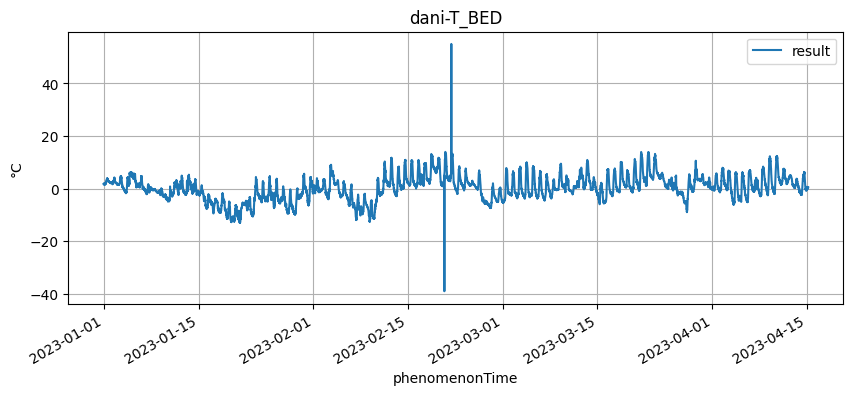

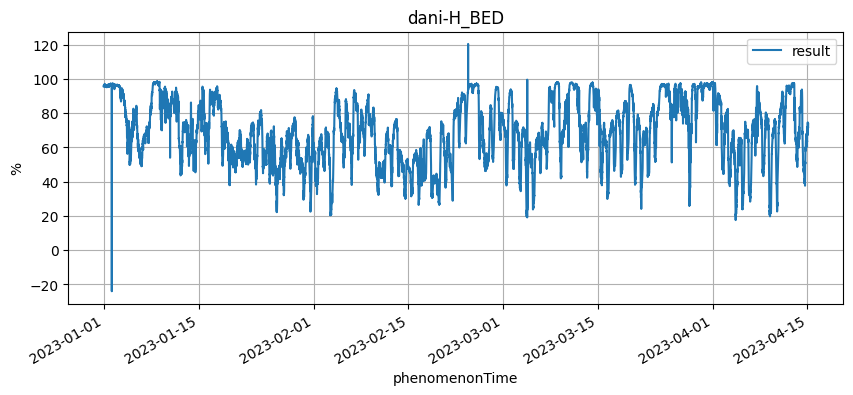

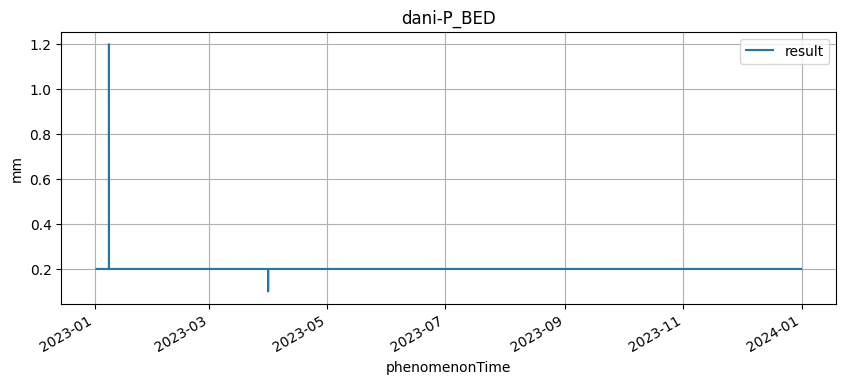

In [12]:
for df in dfs:
    dfs[df].plot(
        y="result",
        title=df,
        figsize=(10, 4),
        grid=True,
        ylabel=f"{dfs[df]['ylabel'][0]}"
    )

### Some quality checks examples

[I 2024-11-21 14:38:09,754] QC for dani-T_BED datastream temperature


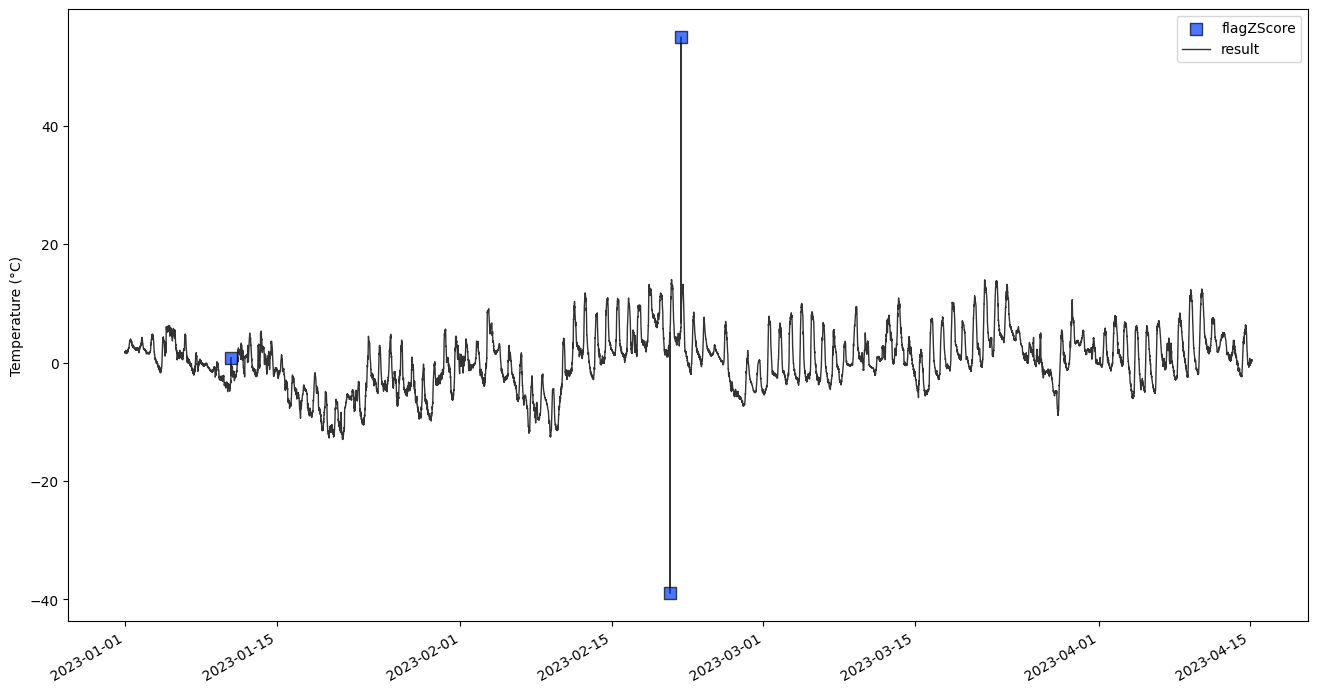

[I 2024-11-21 14:38:10,054] QC for dani-H_BED datastream humidity


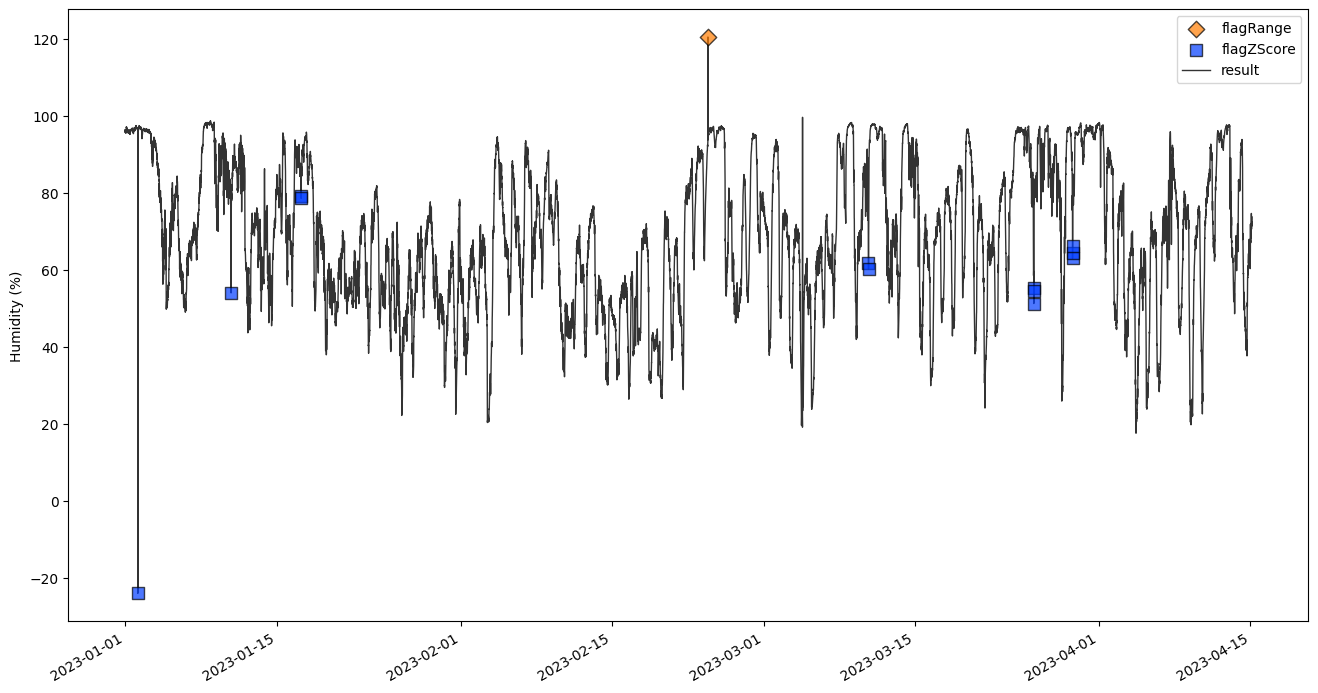

[I 2024-11-21 14:38:10,277] QC for dani-P_BED datastream rain


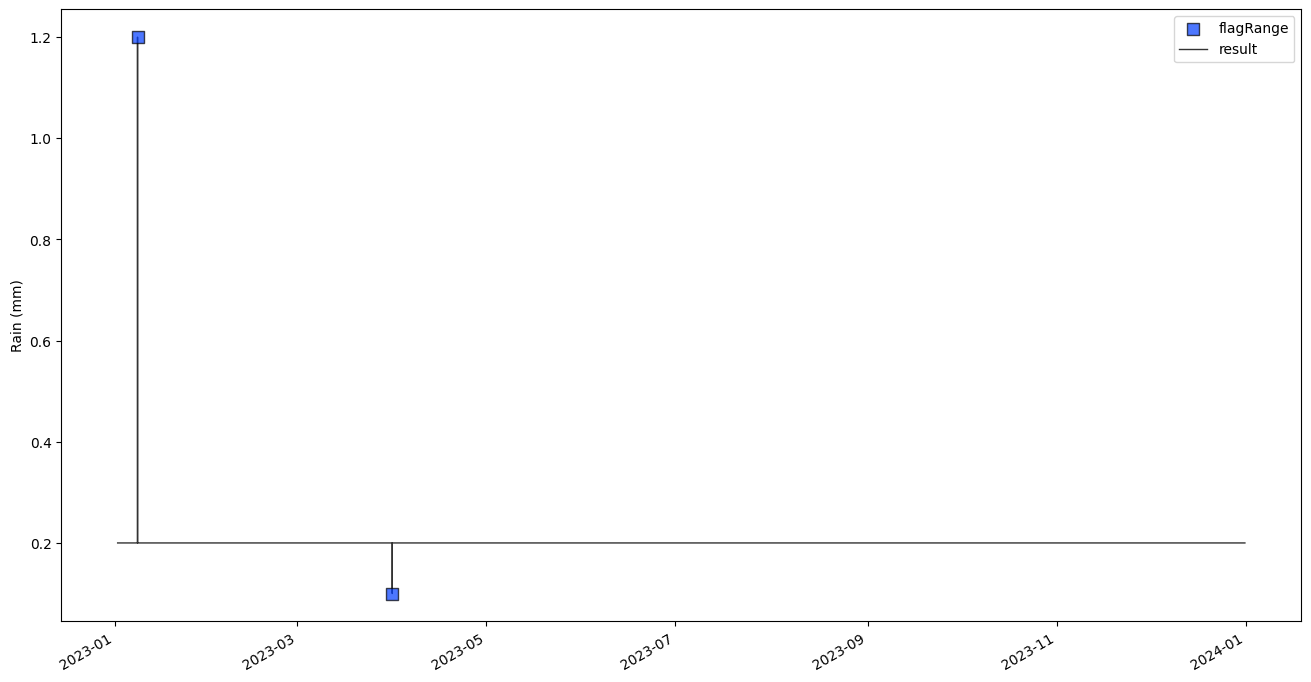

In [13]:
for _qc in qcs:
    if "-T_" in _qc:
        logging.info(f"QC for {_qc} datastream temperature")
        qc = (
            qcs[_qc]
            .flagMissing("result", flag=90) # flag missing values
            .flagConstants("result", thresh=0.1, window="1D", flag=91) # flag constant values
            .flagZScore("result", window="1D", flag=92) # flag z-score
            .flagRange("result", min=-20, max=50, flag=93) # flag range
        )
        dfs[_qc].loc[qc.flags["result"] == 90, "resultQuality"] = 90
        dfs[_qc].loc[qc.flags["result"] == 91, "resultQuality"] = 91
        dfs[_qc].loc[qc.flags["result"] == 92, "resultQuality"] = 92
        dfs[_qc].loc[qc.flags["result"] == 93, "resultQuality"] = 93
        qc.plot(
            "result",
            ax_kwargs={
                "ylabel": f"Temperature (°C)",
            },
        )
        dfs[_qc].update
    elif "-H_" in _qc:
        logging.info(f"QC for {_qc} datastream humidity")
        qc = (
            qcs[_qc]
            .flagMissing("result", flag=90)
            .flagConstants("result", thresh=0.1, window="1D", flag=91)
            .flagZScore("result", window="1D", flag=92)
            .flagRange("result", min=0, max=100, flag=93)
        )
        dfs[_qc].loc[qc.flags["result"] == 90, "resultQuality"] = 90
        dfs[_qc].loc[qc.flags["result"] == 91, "resultQuality"] = 91
        dfs[_qc].loc[qc.flags["result"] == 92, "resultQuality"] = 92
        dfs[_qc].loc[qc.flags["result"] == 93, "resultQuality"] = 93
        qc.plot(
            "result",
            ax_kwargs={
                "ylabel": f"Humidity (%)",
            },
        )
    else:
        logging.info(f"QC for {_qc} datastream rain")
        qc = (
            qcs[_qc]
            .flagMissing("result", flag=90)
            .flagRange("result", min=0.2, max=0.2, flag=91)
        )
        dfs[_qc].loc[qc.flags["result"] == 90, "resultQuality"] = 90
        dfs[_qc].loc[qc.flags["result"] == 91, "resultQuality"] = 91
        qc.plot(
            "result",
            ax_kwargs={
                # "figsize": (10, 4),
                # "grid": True,
                "ylabel": f"Rain (mm)",
            },
        )

### Plots quality flags for each Datastream

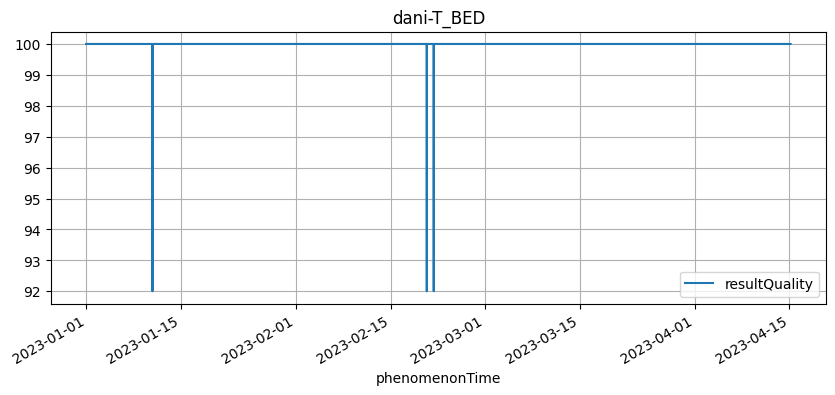

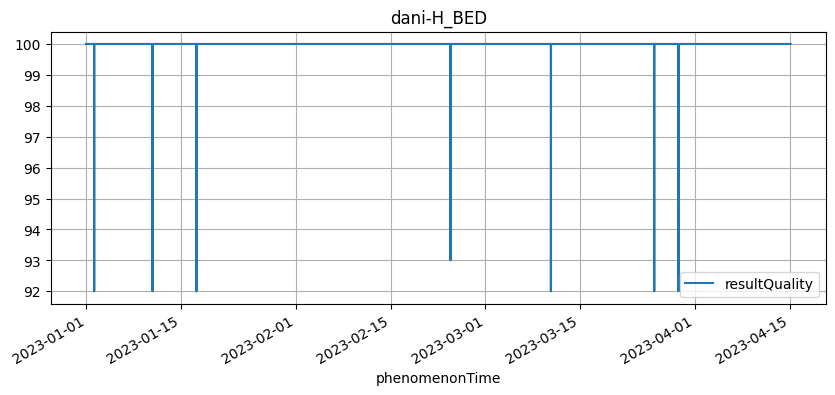

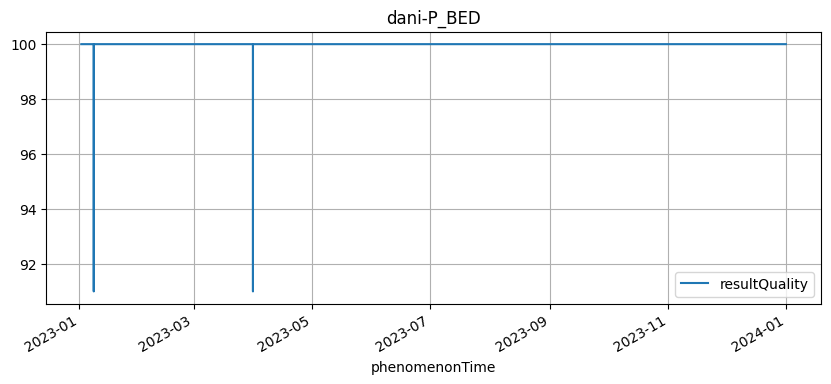

In [14]:
for _df in dfs:
    dfs[_df].plot(y="resultQuality", title=_df, figsize=(10, 4), grid=True)

#### Update Observation outlier

In [15]:
datetime_obs_update = datetime.now()
for df in dfs:
    for row in dfs[df].loc[dfs[df]["resultQuality"]<100].itertuples():
        body = {
            "resultQuality": str(row[8])
        }
        STA.update_observation(
            row[1],
            body,
            commit_message="Quality flagging"
        )
    print(f"Observations of Datastream {df} updated")

Observations of Datastream dani-T_BED updated
Observations of Datastream dani-H_BED updated
Observations of Datastream dani-P_BED updated


#### Retrieve Observation after update

In [16]:

for df in dfs:
    for row in dfs[df].loc[dfs[df]["resultQuality"]<100].itertuples():
        response = STA.query_api(f"Observations({row[1]})?$expand=Commit", travel_time=True)
        json_data = json.dumps(response, indent=2)
        md = f"```json\n{json_data}\n```"
        display(Markdown(md))
        break
    break

[I 2024-11-21 14:42:48,462] URL: https://istsos.org/v4/v1.1/Observations(738543)?$expand=Commit


```json
{
  "@iot.id": 738543,
  "@iot.selfLink": "https://istsos.org/v4/v1.1/Observations(738543)",
  "FeatureOfInterest@iot.navigationLink": "https://istsos.org/v4/v1.1/Observations(738543)/FeatureOfInterest",
  "Datastream@iot.navigationLink": "https://istsos.org/v4/v1.1/Observations(738543)/Datastream",
  "phenomenonTime": "2023-01-10T19:00:00Z",
  "resultTime": "2023-01-10T19:00:00Z",
  "result": 0.83,
  "resultQuality": 92,
  "validTime": null,
  "parameters": null,
  "Commit@iot.navigationLink": "https://istsos.org/v4/v1.1/Observations(738543)/Commit(485)",
  "Commit": {
    "date": "2024-11-21T13:42:28Z",
    "author": "dani",
    "@iot.id": 485,
    "message": "Quality flagging",
    "actionType": "UPDATE",
    "encodingType": "text/plain",
    "@iot.selfLink": "https://istsos.org/v4/v1.1/Commits(485)"
  },
  "@iot.as_of": "2024-11-21T13:42:48Z"
}
```

#### Retrieve Observation outlier at a specific instant (with the as_of value set to one second prior to the update date)

In [17]:
datetime_before_update = datetime_obs_update - timedelta(hours=1, seconds=1)
datetime_before_update = datetime_before_update.isoformat() + "Z"
for df in dfs:
    for row in dfs[df].loc[dfs[df]["resultQuality"] < 100].itertuples():
        response = STA.query_api(
            f"Observations({row[1]})?$expand=Commit&$as_of={datetime_before_update}", travel_time=True
        )
        json_data = json.dumps(response, indent=2)
        md = f"```json\n{json_data}\n```"
        display(Markdown(md))
        break
    break

[I 2024-11-21 14:43:29,854] URL: https://istsos.org/v4/v1.1/Observations(738543)?$expand=Commit&$as_of=2024-11-21T13:42:26.925391Z


```json
{
  "@iot.id": 738543,
  "@iot.selfLink": "https://istsos.org/v4/v1.1/Observations(738543)?$as_of=value: 2024-11-21T13:42:26.925391Z",
  "FeatureOfInterest@iot.navigationLink": "https://istsos.org/v4/v1.1/Observations(738543)/FeatureOfInterest?$as_of=value: 2024-11-21T13:42:26.925391Z",
  "Datastream@iot.navigationLink": "https://istsos.org/v4/v1.1/Observations(738543)/Datastream?$as_of=value: 2024-11-21T13:42:26.925391Z",
  "phenomenonTime": "2023-01-10T19:00:00Z/2023-01-10T19:00:00Z",
  "resultTime": "2023-01-10T19:00:00Z",
  "result": 0.83,
  "resultQuality": 100,
  "validTime": null,
  "parameters": null,
  "systemTimeValidity": "2024-11-21T13:26:19Z/2024-11-21T13:42:28Z",
  "Commit@iot.navigationLink": "https://istsos.org/v4/v1.1/Observations(738543)/Commit(417)",
  "Commit": {
    "date": "2024-11-21T13:26:19Z",
    "author": "dani",
    "@iot.id": 417,
    "message": "Insert observations",
    "actionType": "INSERT",
    "encodingType": "text/plain",
    "@iot.selfLink": "https://istsos.org/v4/v1.1/Commits(417)"
  },
  "@iot.as_of": "2024-11-21T13:42:26.925391Z"
}
```

#### Plot Observations after update

In [ ]:
for df in dfs:
    dfs[df].loc[dfs[df]["resultQuality"] >= 100].plot(
        y="result",
        title=df,
        figsize=(10, 4),
        grid=True,
        ylabel=f"{dfs[df]['ylabel'][0]}",
    )
    dfs[df].loc[dfs[df]["resultQuality"] < 100].plot.scatter(
        x="phenomenonTime",
        y="result",
        grid=True,
    )

#### Retrieve Observation outlier within a time interval (between the date prior to the update and the date following it)

In [ ]:
# response = requests.get(
#     f"{base_url}Observations?$filter=id eq {observation_id}&$from_to={datetime_before_update}, {datetime_obs_update}"
# )
# json_data = json.dumps(response.json(), indent=2)
# md = f"```json\n{json_data}\n```"
# display(Markdown(md))

datetime_obs_update_str = datetime.now().isoformat() + "Z"
datetime_before_update = (datetime.now() - timedelta(hours=24, seconds=1)).isoformat() + "Z"
for df in dfs:
    for row in dfs[df].loc[dfs[df]["resultQuality"] < 100].itertuples():
        response = STA.query_api(
            f"Observations?$filter=id eq {row[1]}&$from_to={datetime_before_update}/{datetime_obs_update_str}",
            travel_time=True,
        )
        json_data = json.dumps(response, indent=2)
        md = f"```json\n{json_data}\n```"
        display(Markdown(md))

In [ ]:

STA.get_token(username, password)

t = STA.query_api("Things?$expand=Locations")
STA.map_things(t)

In [ ]:
for df in dfs:
    dfs[df].to_csv(f"{df}.csv", index=False)